Начнем наш проект с анализа аудитории. Проанализируем, насколько быстро растёт аудитория нашего сервиса, и посмотрим на динамику числа пользователей и курьеров. 
Подсчитаем:
- Число новых пользователей.
- Число новых курьеров.
- Общее число пользователей на текущий день.
- Общее число курьеров на текущий день.

Новыми будем считать тех пользователей и курьеров, которые в данный день совершили своё первое действие в нашем сервисе. Общее число пользователей/курьеров на текущий день — это результат сложения числа новых пользователей/курьеров в текущий день со значениями аналогичного показателя всех предыдущих дней.

In [ ]:
SELECT start_date as date,
       new_users,
       new_couriers,
       (sum(new_users) OVER (ORDER BY start_date))::int as total_users,
       (sum(new_couriers) OVER (ORDER BY start_date))::int as total_couriers
FROM   (SELECT start_date,
               count(courier_id) as new_couriers
        FROM   (SELECT courier_id,
                       min(time::date) as start_date
                FROM   courier_actions
                GROUP BY courier_id) t1
        GROUP BY start_date) t2
    LEFT JOIN (SELECT start_date,
                      count(user_id) as new_users
               FROM   (SELECT user_id,
                              min(time::date) as start_date
                       FROM   user_actions
                       GROUP BY user_id) t3
               GROUP BY start_date) t4 using (start_date)

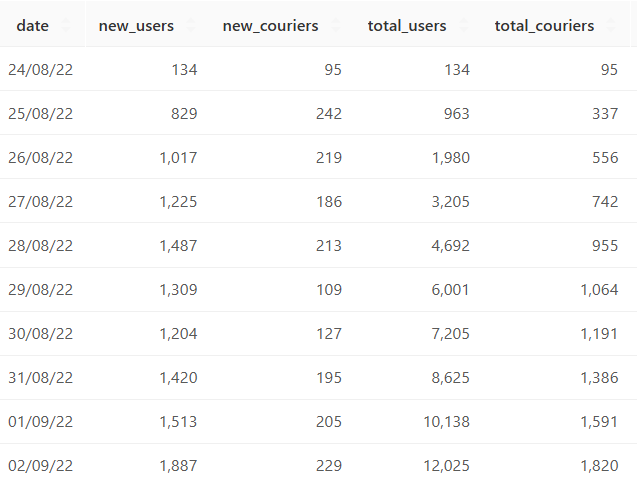

In [2]:
from IPython.display import Image
Image('Table_1.png')

Визуализируем результат и построим графики, отражающие динамику рассчитанных показателей.
На один график поместим динамику новых пользователей и курьеров, а на второй - рост их общего числа.

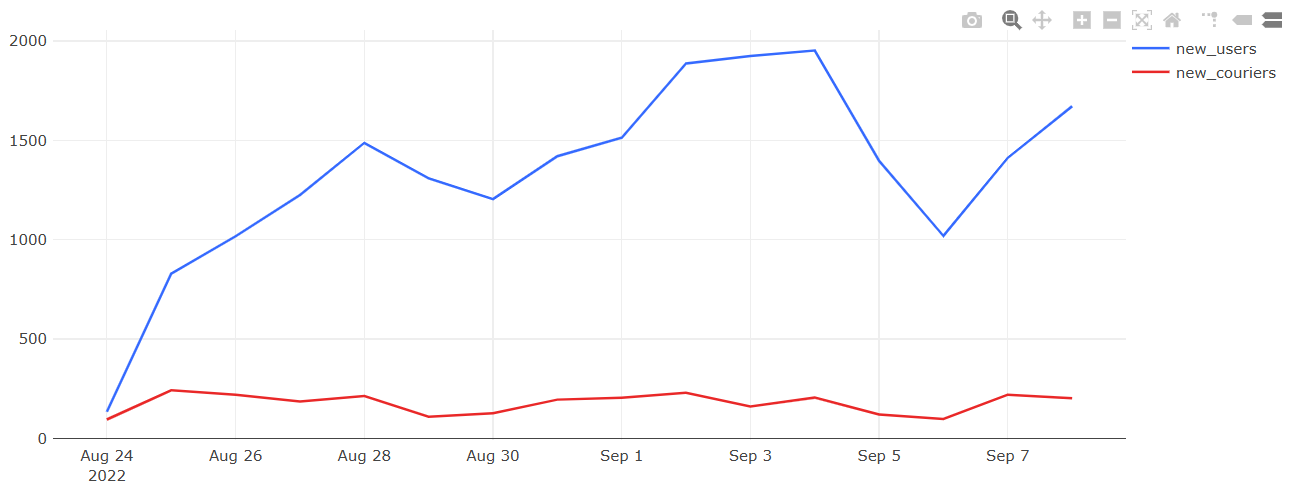

In [3]:
Image('Chart_1_for_table1.png')

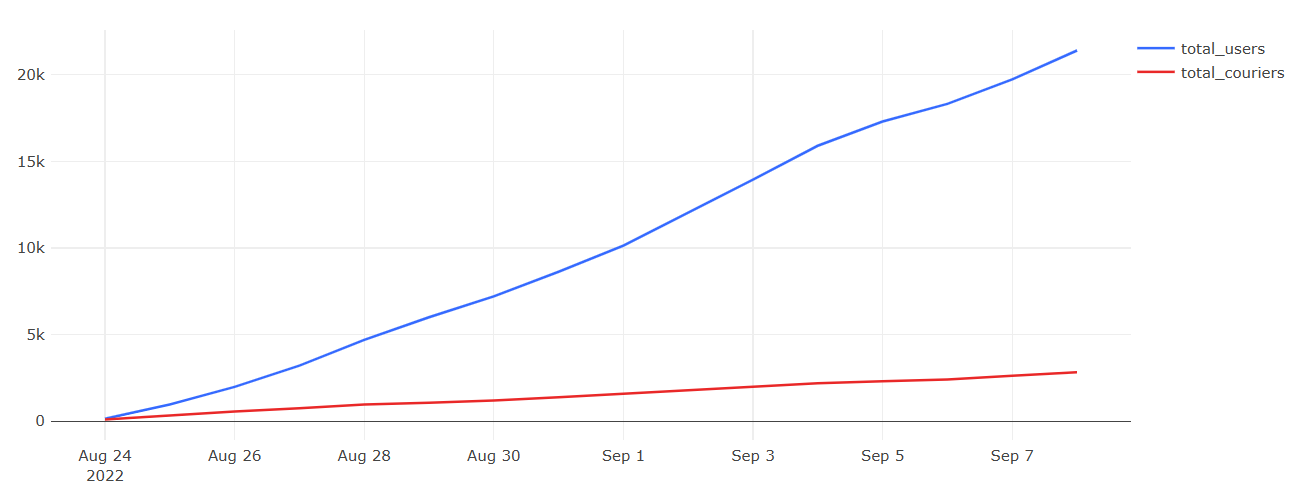

In [4]:
Image('Chart_2_for_table1.png')

In [ ]:
Выводы: 
На первом графике мы видим, что количество новых пользоватлей растет быстрее, чем количество новых курьеров.
Показатели по курьерам более стабильны. На линии пользователей показатели волнообразны, есть ярко выраженная точка роста новых пользоватлей и спада (max 04.09.2022, min 06.09.2022, 
можем предположить, что больше пользоватлеей приходят в выходные и ближе к ним, меньше в начале недели)
Рост новых пользователей идет стремительнее, чем рост новых курьеров.

Анализируя динамику из прошлого шага я обнаружила, что сравнивать абсолютные значения не очень удобно. В этом шаге я посчитаю динамику показателей в относительных величинах.

Дополню запрос из предыдущего шага и теперь для каждого дня, представленного в таблицах user_actions и courier_actions, дополнительно рассчитаю следующие показатели:

-Прирост числа новых пользователей(new_users_change).
-Прирост числа новых курьеров(new_couriers_change).
-Прирост общего числа пользователей(total_users_growth).
-Прирост общего числа курьеров(total_couriers_growth).

In [ ]:
SELECT date, new_users, new_couriers, total_users, total_couriers, new_users_change, new_couriers_change,
       ROUND((total_users - LAG(total_users) OVER (ORDER BY date)) * 100.0/ LAG(total_users) OVER  (ORDER BY date), 2) as total_users_growth,
       ROUND((total_couriers - LAG(total_couriers) OVER (ORDER BY date)) * 100.0/ LAG(total_couriers) OVER  (ORDER BY date), 2) as total_couriers_growth
FROM (SELECT start_date as date,
       new_users,
       new_couriers,
       (sum(new_users) OVER (ORDER BY start_date))::int as total_users,
       (sum(new_couriers) OVER (ORDER BY start_date))::int as total_couriers,
       ROUND((new_users - LAG(new_users) OVER (ORDER BY start_date)) * 100.0/ LAG(new_users) OVER  (ORDER BY start_date), 2) as new_users_change,
       ROUND((new_couriers - LAG(new_couriers) OVER (ORDER BY start_date)) * 100.0/ LAG(new_couriers) OVER  (ORDER BY start_date), 2) as new_couriers_change
FROM   (SELECT start_date,
               count(courier_id) as new_couriers
        FROM   (SELECT courier_id,
                       min(time::date) as start_date
                FROM   courier_actions
                GROUP BY courier_id) t1
        GROUP BY start_date) t2
    LEFT JOIN (SELECT start_date,
                      count(user_id) as new_users
               FROM   (SELECT user_id,
                              min(time::date) as start_date
                       FROM   user_actions
                       GROUP BY user_id) t3
               GROUP BY start_date) t4 using (start_date)) t1

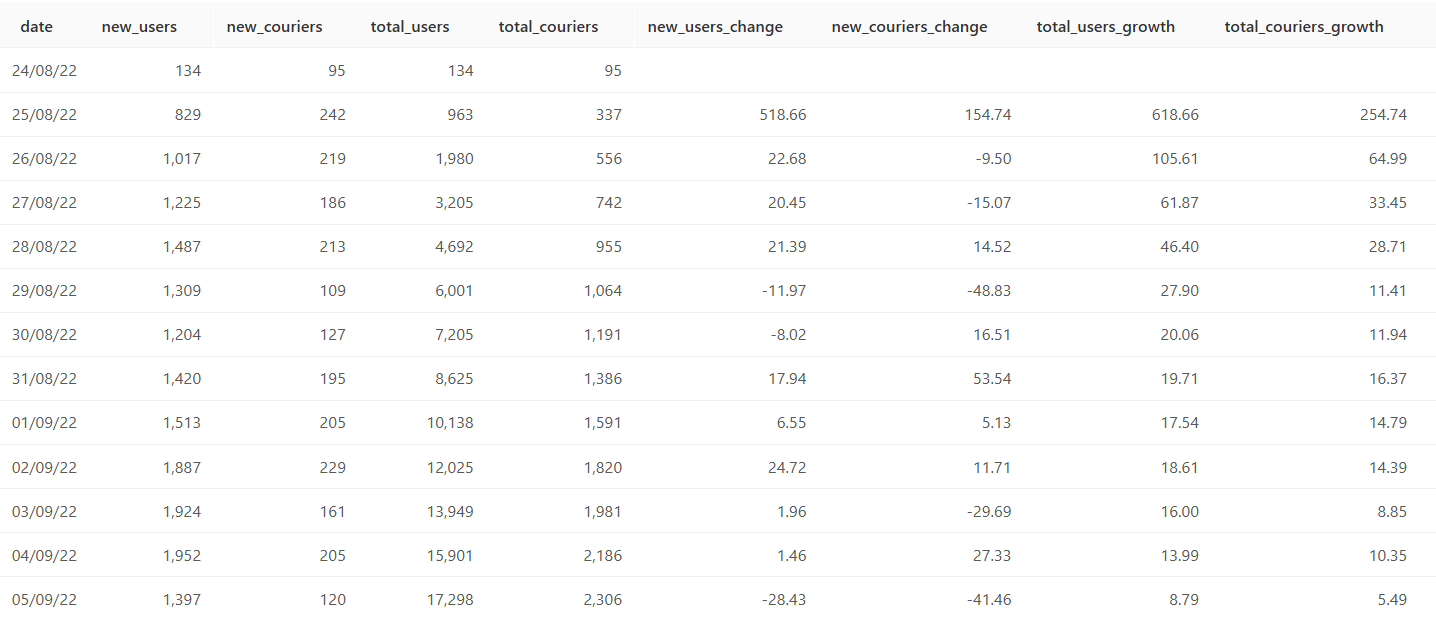

In [5]:
Image('Table_2.png')

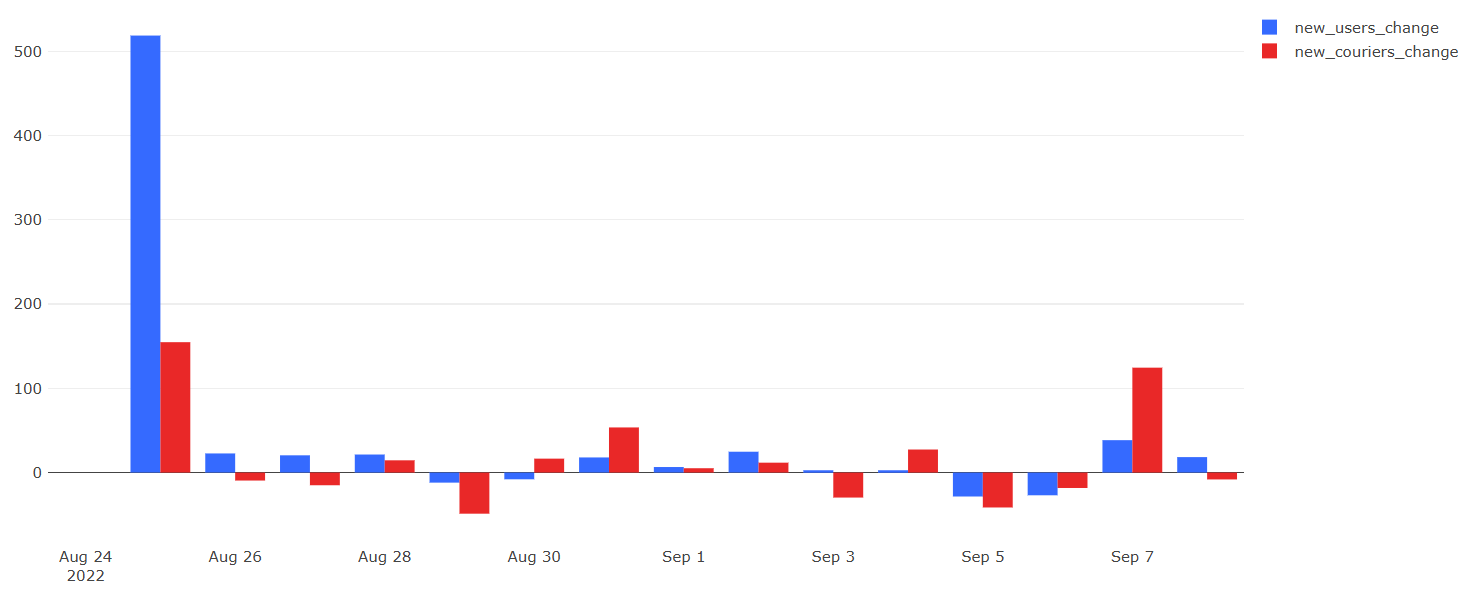

In [6]:
Image('Chart_1_for_table2.png')

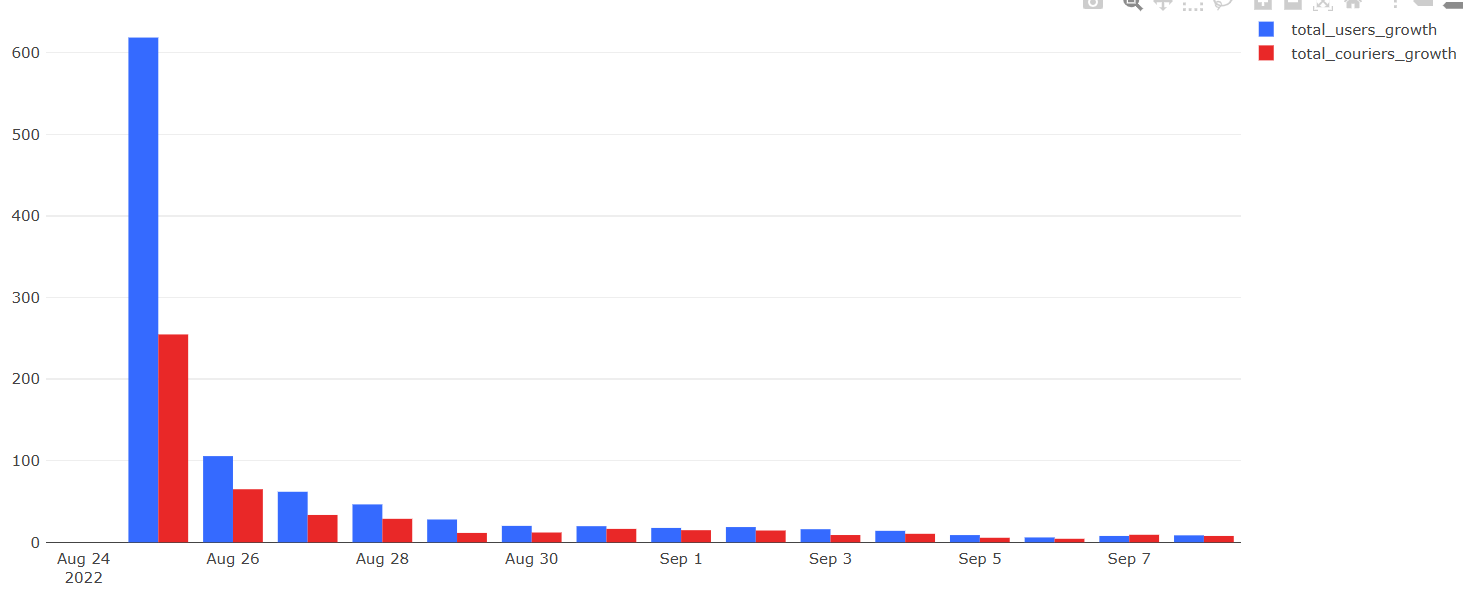

In [7]:
Image('Chart_2_for_table2.png')

In [ ]:
Выводы:
Анализируя графики мы видим, что темпы роста общего числа пользователей и курьеров затухают.
В даты 31.08, 04.09, 07.09 прирост числа новых курьеров заметно опережал темп прироста числа новых пользователей.
Глядя  на график с относительными показателями мы не можем сказать, что показатель числа новых курьеров более стабилен, чем показатель числа новых пользователей.

In [ ]:
Теперь посмотрим на аудиторию немного под другим углом — посчитаем не просто всех пользователей, а именно ту часть, которая оформляет и оплачивает заказы в сервисе. 
Заодно выясним, какую долю платящие пользователи составляют от их общего числа.

Рассчитаем следующие показатели:
- Число платящих пользователей.
- Число активных курьеров.
- Долю платящих пользователей в общем числе пользователей на текущий день.
- Долю активных курьеров в общем числе курьеров на текущий день.

Платящими считаем тех пользователей, которые в данный день оформили хотя бы один заказ, который в дальнейшем не был отменен.
Курьеров будем считать активными, если в данный день они приняли хотя бы один заказ, который был доставлен (возможно, уже на следующий день), или доставили любой заказ.

In [ ]:
SELECT date, paying_users, active_couriers,
       ROUND (100*paying_users/total_users::DECIMAL,2) AS paying_users_share,
       ROUND (100*active_couriers/total_couriers::DECIMAL,2) AS active_couriers_share
FROM(
     SELECT time::DATE AS date, COUNT (DISTINCT user_id) FILTER (WHERE action='create_order' AND order_id NOT IN (SELECT order_id FROM user_actions WHERE action='cancel_order')) AS paying_users
     FROM user_actions
     GROUP BY date) AS t1
FULL JOIN
    (SELECT time::DATE AS date, COUNT (DISTINCT courier_id) FILTER (WHERE action='accept_order' AND order_id IN (SELECT order_id FROM courier_actions WHERE action='deliver_order') OR action ='deliver_order') AS active_couriers
     FROM courier_actions
     GROUP BY date) AS t2
USING (date)
FULL JOIN
     (SELECT date, new_users, new_couriers,
             SUM (new_users) OVER (ORDER BY date)::int AS total_users,
             SUM (new_couriers) OVER (ORDER BY date)::int AS total_couriers
      FROM (SELECT date, COUNT (user_id) as new_users
            FROM(
                 SELECT user_id, MIN(time)::DATE as date
                 FROM user_actions
                 GROUP BY user_id) t3
            GROUP BY date) AS t4
      FULL JOIN
           (SELECT date, COUNT (courier_id) as new_couriers
            FROM(
                 SELECT courier_id, MIN(time)::DATE as date
                 FROM courier_actions 
                 GROUP BY courier_id) t5
            GROUP BY date) AS t6
       USING (date)
      )t7
USING (date)
ORDER BY date;

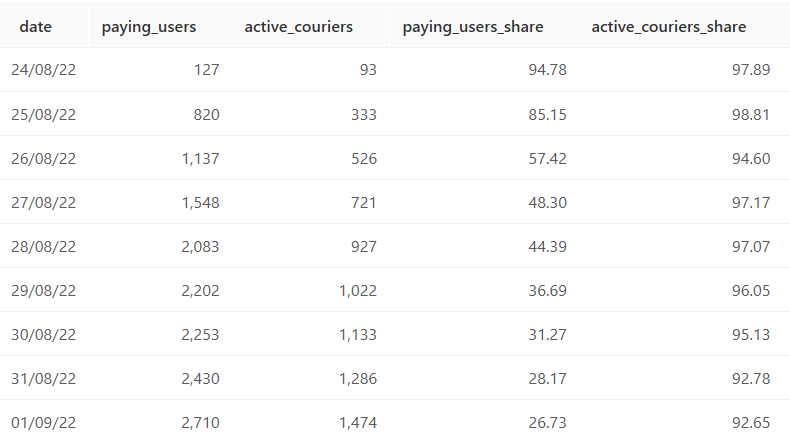

In [8]:
Image('Table_3.png')

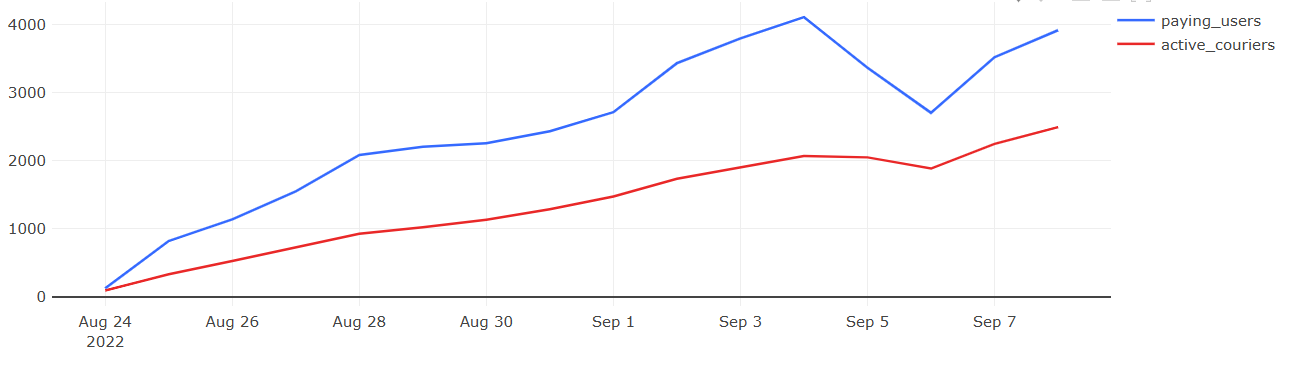

In [9]:
Image('Chart_1_for_table3.png')

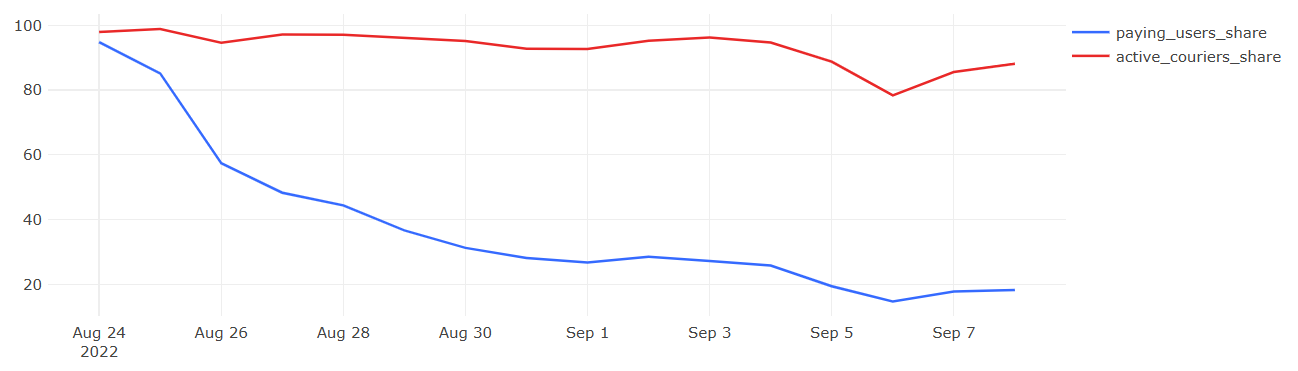

In [11]:
Image('Chart2_for_table3.png')

In [ ]:
Выводы: 
По данным отображаемым на графике мы не можем сказать, что с общим числом пользователей и курьеров растёт число платящих пользователей и активных курьеров.
Рассмотрев долю платящих пользователей и активных курьеров, мы видим незакономерную динамику. Актвиных курьеров больше, чем платящих пользоватлей.
Абсолютные показатели (верхний график) растут, но относительные (доли, на нижнем графике) показывают снижение доли платящих пользователей, тогда как доля активных курьеров остается высокой.

In [ ]:
Сейчас подробнее остановимся на платящих пользователях, копнём немного глубже и выясним, как много платящих пользователей совершают более одного заказа в день. В конце концов нам важно понимать, 
как в большинстве своём ведут себя наши пользователи — они заходят в приложение, чтобы сделать всего один заказ, или же наш сервис настолько хорош, что они готовы пользоваться им несколько раз в день.

Для каждого дня, рассчитаем следующие показатели:

- Долю пользователей, сделавших в этот день всего один заказ, в общем количестве платящих пользователей.
- Долю пользователей, сделавших в этот день несколько заказов, в общем количестве платящих пользователей.


In [ ]:
WITH user_orders AS (
    SELECT 
        user_id,
        time::DATE AS date,
        COUNT(order_id) AS order_count
    FROM user_actions
    WHERE action = 'create_order'
        AND order_id NOT IN (
            SELECT order_id FROM user_actions WHERE action = 'cancel_order'
        )
    GROUP BY user_id, date
),
paying_users_summary AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS total_paying_users
    FROM user_orders
    GROUP BY date
),
one_order_users AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS users_with_1_order
    FROM user_orders
    WHERE order_count = 1
    GROUP BY date
),
few_orders_users AS (
    SELECT 
        date,
        COUNT(DISTINCT user_id) AS users_with_few_orders
    FROM user_orders
    WHERE order_count >=2
    GROUP BY date)
SELECT 
    p.date, 
    ROUND(users_with_1_order::DECIMAL / NULLIF(total_paying_users, 0) * 100, 2) AS single_order_users_share,
    ROUND(users_with_few_orders::DECIMAL / NULLIF(total_paying_users, 0) * 100, 2) AS several_orders_users_share
FROM paying_users_summary p
LEFT JOIN one_order_users o USING (date)
LEFT JOIN few_orders_users f USING (date)
ORDER BY p.date;

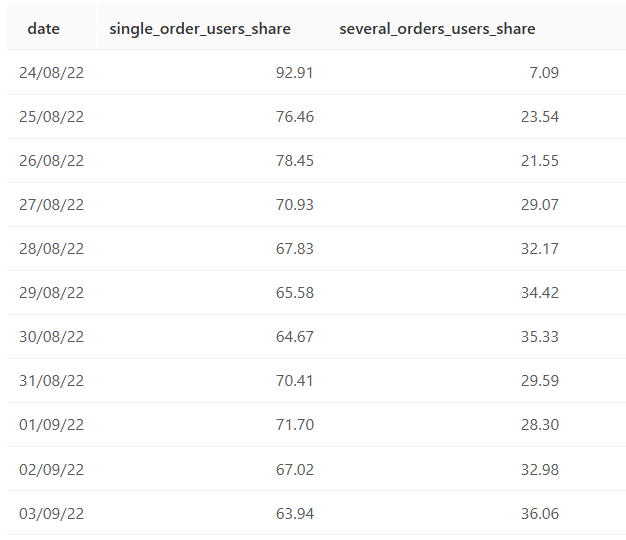

In [12]:
Image('Table_4.png')

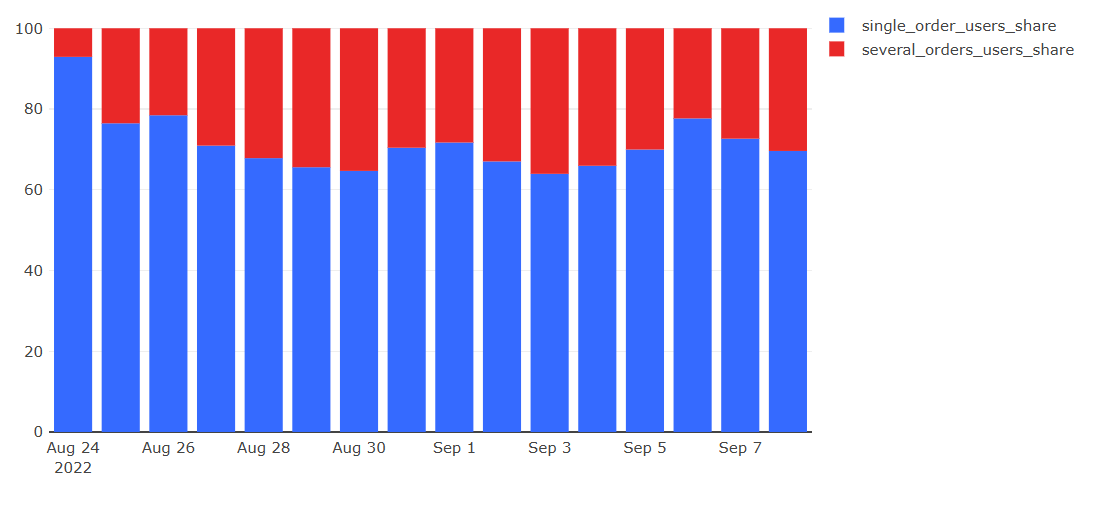

In [13]:
Image('Chart_1_for_table4.png')

In [ ]:
Выводы:
В среднем доля пользоватлеей с несколькими заказами держится в районе 20-25%.
Мы видим, что значения в первый день значительно отличаются от общей кратины, его можно считать аномальным. 

Продолжим изучать наш сервис и рассчитаем несколько показателей, связанных с заказами.

Для каждого дня, представленного в таблице user_actions, рассчитаем следующие показатели:

- Общее число заказов.
- Число первых заказов (заказов, сделанных пользователями впервые).
- Число заказов новых пользователей (заказов, сделанных пользователями в тот же день, когда они впервые воспользовались сервисом).
- Долю первых заказов в общем числе заказов (долю п.2 в п.1).
- Долю заказов новых пользователей в общем числе заказов (долю п.3 в п.1).

In [ ]:
WITH orders AS (
    SELECT time::DATE AS date, COUNT(DISTINCT order_id) AS orders
    FROM user_actions
    WHERE action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
    GROUP BY date
),
first_orders AS (
    SELECT time::DATE AS date, user_id, order_id,
           ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY time::DATE) AS rn
    FROM user_actions
    WHERE action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
),
new_users_orders AS (
    SELECT date, COUNT(order_id) AS new_users_orders
    FROM (
        SELECT user_id, time::DATE AS date, order_id, action,
               MIN(time::DATE) OVER (PARTITION BY user_id) AS start_date
        FROM user_actions
    ) AS t
    WHERE date = start_date
          AND action = 'create_order'
          AND order_id NOT IN (
              SELECT order_id FROM user_actions WHERE action = 'cancel_order'
          )
    GROUP BY date
)

SELECT o.date, 
       o.orders, 
       COUNT(DISTINCT f.user_id) AS first_orders, 
       COALESCE(n.new_users_orders, 0) AS new_users_orders,
       ROUND(COUNT(DISTINCT f.user_id) * 100.0 / NULLIF(o.orders, 0), 2) AS first_orders_share,
       ROUND(COALESCE(n.new_users_orders, 0) * 100.0 / NULLIF(o.orders, 0), 2) AS new_users_orders_share
FROM orders o
LEFT JOIN first_orders f ON o.date = f.date AND f.rn = 1
LEFT JOIN new_users_orders n ON o.date = n.date
GROUP BY o.date, o.orders, n.new_users_orders
ORDER BY o.date;

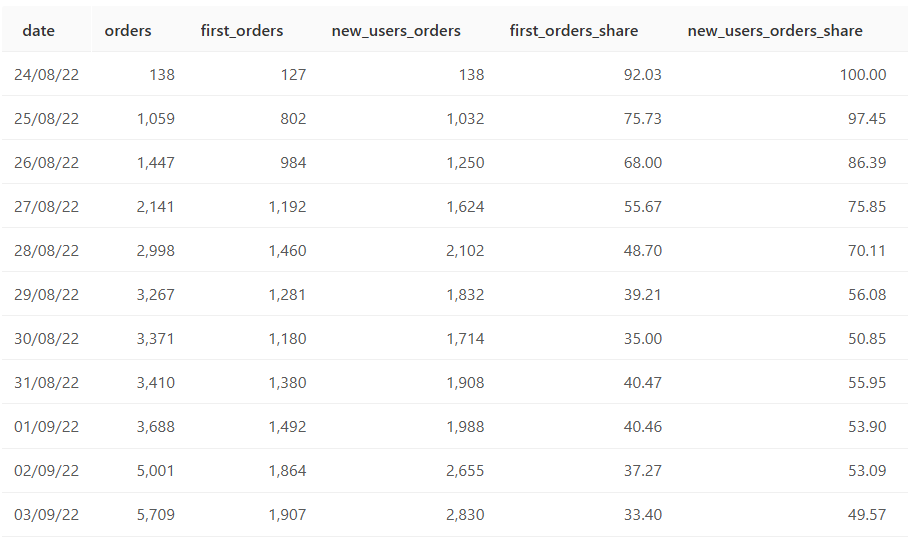

In [10]:
Image('Table_5.png')

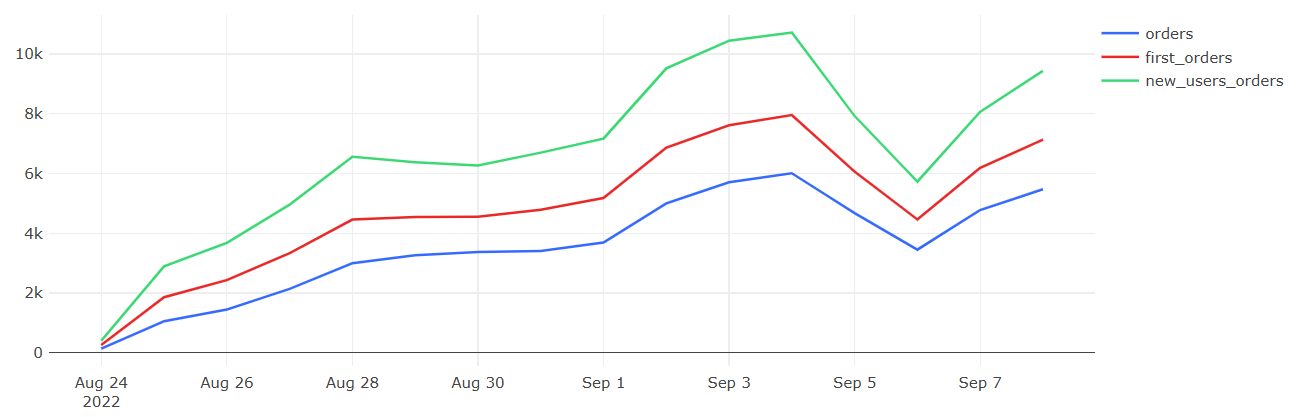

In [4]:
Image('Chart_1_for_table5.png')

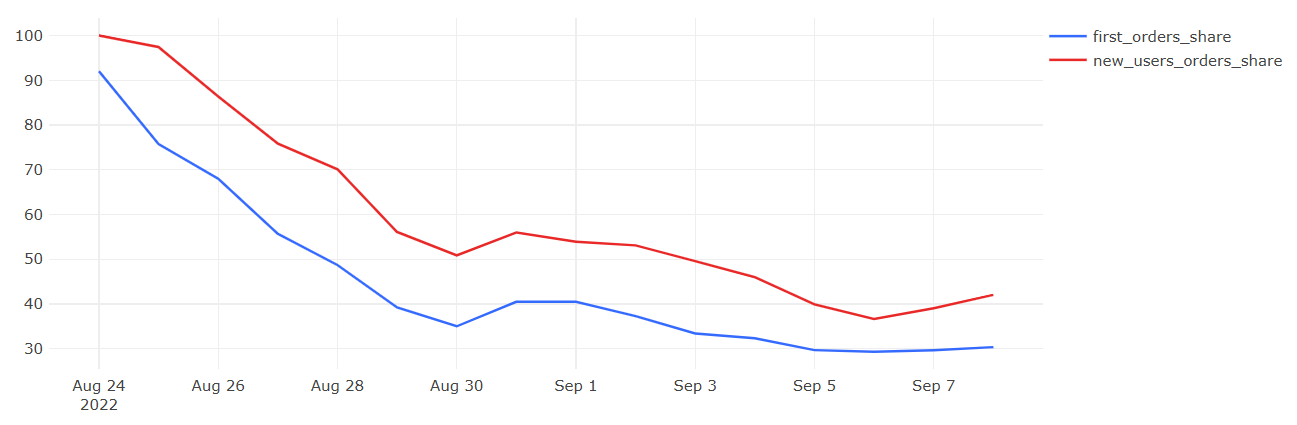

In [9]:
Image('Chart_2_for_table5.png')

Выводы:
На первом графике мы можем отметить, что с ростом количества всех заказов растут показатели числа первых заказов и числа заказов новых пользователей, также и наоборот. 


In [ ]:
Проанализируйте построенные графики и попробуйте ответить на следующие вопросы:

Какая в целом динамика у абсолютных показателей? Можно ли сказать, что вместе с ростом количества всех заказов растут показатели числа первых заказов и числа заказов новых пользователей?
Что можно сказать о динамике относительных показателей? Можно ли считать её в целом закономерной? Как, на ваш взгляд, будут вести себя эти показатели в долгосрочной перспективе: они будут расти или снижаться?